<table class="table table-bordered">
    <tr>
        <th style="text-align:center; width:25%"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 250px; height: 125px; "></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Practical 4 - Using Convnets with Small Datasets</h2><h3>AY2020/21 Semester</h3></th>
    </tr>
</table>

In [1]:
from tensorflow import keras
print('keras: ', keras.__version__)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

keras:  2.2.4-tf


## Objectives
After completing this practical exercise, students should be able to:
1. [Train a convnet from scratch on a small dataset](#demo)
2. [Exercise: Tune parameters of a convnet model](#exc)

## 1. Training a convnet from scratch on a small dataset <a id='demo' />

In this practical example, we will focus on classifying images as "dogs" or "cats". We will start by naively training a small convnet on our training samples, without any regularization, to set a baseline for what can be achieved. This will get us to a classification accuracy of around 70%. At that point, our main issue will be overfitting. Then we will introduce *data augmentation*, a powerful technique for mitigating overfitting in computer vision. By leveraging data augmentation, we will improve our network to reach an accuracy of around 80%.

### 1.1 Downloading the data

The cats vs. dogs dataset that we will use isn't packaged with Keras. It was made available by Kaggle.com as part of a computer vision competition in late 2013, back when convnets weren't quite mainstream. The original dataset is available at: 
`https://www.kaggle.com/c/dogs-vs-cats/data`.

This original dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543MB large (compressed). In this Practical we will use a subset ("cats_and_dogs_small.zip") of the original dataset. It contains 4000 pictures of cats and dogs (2000 cats, 2000 dogs) and we will use 2000 pictures (1000 cats, 1000 dogs) for training, 1000 (500 cats, 500 dogs) for validation, and finally 1000 (500 cats, 500 dogs) for testing. You can download this small dataset ("cats_and_dogs_small.zip", around 90MB) from MEL and then unzip it. After that please assign directory you save the images to base_dir as shown below.

In [2]:
import os
#base_dir is the directory where you stored the cats and dogs dataset
base_dir = 'C:/Users/lji6/Desktop/Modules_Local/DL/Data/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

### 1.2 Building our network

Our convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers. We start from inputs of size 50x50 (a somewhat arbitrary choice), we end up with output of size 1x1 right before the `Flatten` layer.

Note that the depth of the output is progressively increasing in the network (from 32 to 128), while the size of the output is 
decreasing (from 48x48 to 1x1). This is a pattern that you will see in almost all convnets.

Since we are attacking a binary classification problem, we are ending the network with a single unit (a `Dense` layer of size 1) and a `sigmoid` activation. This unit will output the classification probability of one class or the other.

In [3]:
from tensorflow.keras import layers
from tensorflow.keras import models

# We set image size as 50*50.
img_size = 50

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(img_size, img_size, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Let's take a look at how the dimensions of the Output Shape change with every successive layer:

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 128)         1

For our compilation step, we'll go with the `RMSprop` optimizer as usual. Since we ended our network with a single sigmoid unit, we will use binary crossentropy as our loss.

In [5]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### 1.3 Data preprocessing

As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our 
network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image 
processing helper tools, located at `tensorflow.keras.preprocessing.image`. It contains the class `ImageDataGenerator` which allows to 
quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we will use here.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 50x50
        target_size=(img_size, img_size),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_size, img_size),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let's take a look at the output of one of these generators: it yields batches of 50x50 RGB images (shape `(20, 50, 50, 3)`) and binary 
labels (shape `(20,)`). 20 is the number of samples in each batch (the batch size). Note that the generator yields these batches 
indefinitely: it just loops endlessly over the images present in the target folder, so we need to `break` the iteration loop at some point.

In [7]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 50, 50, 3)
labels batch shape: (20,)


Let's fit our model to the data using the generator. We do it using the `fit_generator` method, the equivalent of `fit` for data generators like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely. 
Because the data is being generated endlessly, the generator needs to know how many samples to draw from the generator before declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case, batches are 20-sample large, so it will take 100 batches (=20*100 samples) until we see our target of 2000 samples.

When using `fit_generator`, one may pass a `validation_data` argument, much like with the `fit` method. Importantly, this argument is mostly a data generator.  After you pass a generator to `validation_data`, then 
this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, which tells the process how many batches to draw from the validation generator for evaluation.

In [8]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100, # batch: 20 * 100 = 2000 training images
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50) # 20 * 50 = 1000 = 1000 validation images

Epoch 1/30
100/100 [==============================] - 8s 84ms/step - loss: 0.6897 - acc: 0.5230 - val_loss: 0.6956 - val_acc: 0.5000
Epoch 2/30
100/100 [==============================] - 6s 58ms/step - loss: 0.6844 - acc: 0.5660 - val_loss: 0.6758 - val_acc: 0.5890
Epoch 3/30
100/100 [==============================] - 6s 59ms/step - loss: 0.6696 - acc: 0.5985 - val_loss: 0.6632 - val_acc: 0.6030
Epoch 4/30
100/100 [==============================] - 6s 59ms/step - loss: 0.6559 - acc: 0.6235 - val_loss: 0.6586 - val_acc: 0.6010
Epoch 5/30
100/100 [==============================] - 6s 59ms/step - loss: 0.6455 - acc: 0.6375 - val_loss: 0.6975 - val_acc: 0.5610
Epoch 6/30
100/100 [==============================] - 6s 59ms/step - loss: 0.6399 - acc: 0.6350 - val_loss: 0.6399 - val_acc: 0.6260
Epoch 7/30
100/100 [==============================] - 6s 59ms/step - loss: 0.6298 - acc: 0.6505 - val_loss: 0.6470 - val_acc: 0.6170
Epoch 8/30
100/100 [==============================] - 6s 59ms/step - 

It is good practice to always save your models after training:

In [9]:
#model.save('cats_and_dogs_small_1.h5')

Let's plot the loss and accuracy of the model over the training and validation data during training:

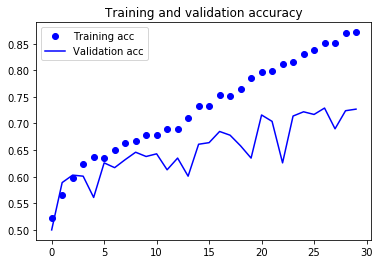

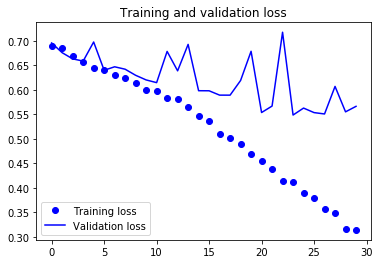

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We can easily see overfitting through these plots. Our training accuracy increases linearly over time, until it reaches nearly 90%, while our validation accuracy stalls at around 70%. Our validation loss reaches its minimum after only a few epochs then stalls, while the training loss keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. You already know about a number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We are now going to introduce a new one, specific to computer vision, and used almost universally when processing images with deep learning models: *data augmentation*.

### 1.4 Using data augmentation

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. 
Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data 
augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number 
of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same 
picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` 
instance. Let's get started with an example:

In [11]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures 
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal 
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

Using TensorFlow backend.


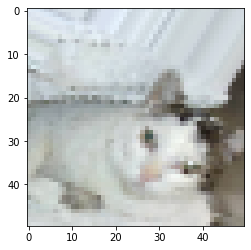

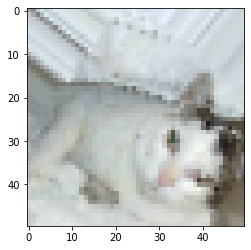

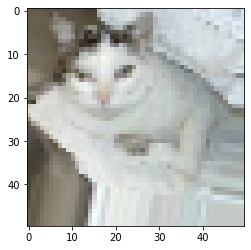

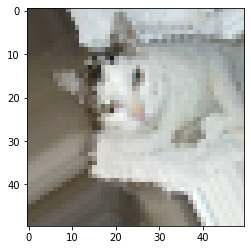

In [12]:
# This is module with image preprocessing utilities
# import os
# import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image
train_cats_dir = os.path.join(base_dir, 'train/cats')

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[9]

# Read the image and resize it
img = image.load_img(img_path, target_size=(img_size, img_size))

# Convert it to a Numpy array with shape (50, 50, 3)
x = image.img_to_array(img)

# Reshape it to (1, 50, 50, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
        

plt.show()

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs 
that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information, 
we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight 
overfitting, we will also add a Dropout layer to our model, right before the densely-connected classifier:

In [13]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(img_size, img_size, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Let's train our network using data augmentation and dropout:

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 50x50
        target_size=(img_size, img_size),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_size, img_size),
        batch_size=20,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 8s 80ms/step - loss: 0.6936 - acc: 0.5035 - val_loss: 0.6920 - val_acc: 0.4990
Epoch 2/100
100/100 [==============================] - 7s 71ms/step - loss: 0.6917 - acc: 0.5265 - val_loss: 0.6895 - val_acc: 0.5240
Epoch 3/100
100/100 [==============================] - 7s 72ms/step - loss: 0.6899 - acc: 0.5370 - val_loss: 0.6883 - val_acc: 0.5050
Epoch 4/100
100/100 [==============================] - 7s 71ms/step - loss: 0.6874 - acc: 0.5370 - val_loss: 0.6849 - val_acc: 0.5320
Epoch 5/100
100/100 [==============================] - 7s 72ms/step - loss: 0.6830 - acc: 0.5435 - val_loss: 0.6734 - val_acc: 0.5790
Epoch 6/100
100/100 [==============================] - 7s 73ms/step - loss: 0.6776 - acc: 0.5825 - val_loss: 0.6737 - val_acc: 0.5650
Epoch 7/100
100/100 [==============================] - 7s 72ms/step - loss: 0.6734 - acc: 0.5715 - val_loss: 0.6

100/100 [==============================] - 8s 82ms/step - loss: 0.5242 - acc: 0.7465 - val_loss: 0.5490 - val_acc: 0.7070
Epoch 73/100
100/100 [==============================] - 8s 83ms/step - loss: 0.5131 - acc: 0.7480 - val_loss: 0.5296 - val_acc: 0.7250
Epoch 74/100
100/100 [==============================] - 8s 83ms/step - loss: 0.5123 - acc: 0.7485 - val_loss: 0.5196 - val_acc: 0.7290
Epoch 75/100
100/100 [==============================] - 8s 81ms/step - loss: 0.5116 - acc: 0.7485 - val_loss: 0.5289 - val_acc: 0.7230
Epoch 76/100
100/100 [==============================] - 8s 82ms/step - loss: 0.5121 - acc: 0.7605 - val_loss: 0.5714 - val_acc: 0.7060
Epoch 77/100
100/100 [==============================] - 8s 81ms/step - loss: 0.5138 - acc: 0.7535 - val_loss: 0.5656 - val_acc: 0.7080
Epoch 78/100
100/100 [==============================] - 8s 82ms/step - loss: 0.4957 - acc: 0.7525 - val_loss: 0.4935 - val_acc: 0.7520
Epoch 79/100
100/100 [==============================] - 8s 79ms/step

In [15]:
#model.save('cats_and_dogs_small_2.h5')

Let's plot our results again:

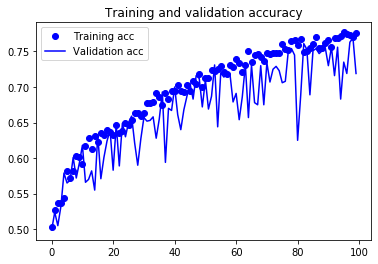

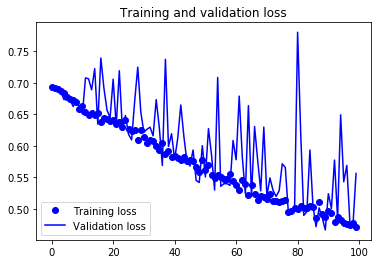

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Thanks to data augmentation and dropout, we are no longer overfitting: the training curves are rather closely tracking the validation curves. We are now able to reach an accuracy of 75%, a 5% relative improvement over the non-regularized model.

## 2. Exercise - Tuning model parameters <a id='exc' />

Please try below two scenerios, make changes accordingly and train the models for 100 epochs as above:

**Scenerio A:** 

* Reduce training `batch_size` from 20 to 10 and increase `steps_per_epoch` from 100 to 200 

(remember `steps_per_epoch` = total number of samples // `batch_size`)

**Scenerio B:** 

* Increase the Optimizer Learning Rate (`optimizers.RMSprop(lr=1e-4)`) from `1e-4` to `2*1e-4`. 

Observe the training and validation accuracy curves for both scenerios. 

Provide your codes & comments in the below boxes.

### 2.1 Scenerio A

In [ ]:
# Task 1: Build and Compile the Model


In [ ]:
# Task 2: Use ImageDataGenerator to do Data preprocessing and Data Augmentation
# Remember to reduce training batch_size from 20 to 10 and increase steps_per_epoch from 100 to 200


# Note that the validation data should not be augmented!


In [ ]:
# Task 3: Fit the model 


In [ ]:
# Task 4: Plot the accuracy (training and validation) and loss curves (training and validation)


In [ ]:
# Task 5: Comments


### 2.2 Scenerio B

In [ ]:
# Task 1: Build and Compile the Model
# Remember to reduce the Optimizer learning rate from 1e-4 to 2*1e-4


In [ ]:
# Task 2: Use ImageDataGenerator to do Data preprocessing and Data Augmentation


In [ ]:
# Task 3: Fit the model 


In [ ]:
# Task 4: Plot the accuracy (training and validation) and loss curves (training and validation)


In [ ]:
# Task 5: Comments
